### Dependencies

In [150]:
import os
import sys
sys.path.insert(0, os.path.join(os.environ["SPARK_HOME"], "python"))
sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python/lib/py4j-0.10.9.2-src.zip"))

In [151]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("HelloLines") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.memory", "1024M") \
    .getOrCreate()
sc = spark.sparkContext

In [156]:
from pyspark.sql.functions import min, avg, max
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import from_unixtime
import numpy as np

### Exploring the dataset

In [134]:
playlists_path = "hdfs://localhost:9000/tp1/playlist.json"
tracks_path = "hdfs://localhost:9000/tp1/tracks.json"

In [135]:
rdd_playlists = sc.textFile(playlist_path)
rdd_tracks = sc.textFile(tracks_path)

print(f"Number of playlist lines: {rdd_playlists.count()}")
print(f"Number of track lines: {rdd_tracks.count()}")

Number of playlist lines: 161000


Number of track lines: 10760544


In [136]:
df_playlists = spark.read.json(playlists_path)
df_playlists.printSchema()
df_playlists.show()

root
 |-- collaborative: string (nullable = true)
 |-- description: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- name: string (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_artists: long (nullable = true)
 |-- num_edits: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- pid: long (nullable = true)

+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+
|collaborative|description|duration_ms|modified_at|                name|num_albums|num_artists|num_edits|num_followers|num_tracks|pid|
+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+
|        false|       NULL|   11532414| 1493424000|          Throwbacks|        47|         37|        6|            1|        52|  0|
|        fal

In [137]:
df_tracks = spark.read.json(tracks_path)
df_tracks.printSchema()
df_tracks.show()

root
 |-- album_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- pid: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_uri: string (nullable = true)

+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|duration_ms|pid|pos|          track_name|           track_uri|
+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|     226863|  0|  0|Lose Control (fea...|spotify:track:0Ua...|
|         In The Zone|spotify:album:0z7...|    Britn

### Task 1 - Statistics about songs duration

#### 1. Generate a table containing the minimum, average and maximum duration, in milliseconds, of the songs in the dataset.

In [138]:
duration_stats = df_tracks.agg(
    min("duration_ms").alias("Min Duration (ms)"),
    avg("duration_ms").alias("Average Duration (ms)"),
    max("duration_ms").alias("Max Duration (ms)")
)

duration_stats.show()

+-----------------+---------------------+-----------------+
|Min Duration (ms)|Average Duration (ms)|Max Duration (ms)|
+-----------------+---------------------+-----------------+
|                0|   234408.54976216817|         10435467|
+-----------------+---------------------+-----------------+



#### 2. Compute the first and third quartiles as well as the interquartile range (IRQ)

In [139]:
quartiles = df_tracks.approxQuantile("duration_ms", [0.25, 0.75], 0.01)

Q1 = quartiles[0]
Q3 = quartiles[1]
IRQ = Q3 - Q1

print(f"First Quartile (Q1): {Q1} ms")
print(f"Third Quartile (Q3): {Q3} ms")
print(f"Interquartile Range (IRQ): {IQR} ms")

First Quartile (Q1): 198026.0 ms
Third Quartile (Q3): 258133.0 ms
Interquartile Range (IRQ): 60107.0 ms


#### 3. Compute the set of songs with durations that are not outliers, as defined by the IQRR methodology

In [140]:
inf_limit = Q1 - 1.5*IRQ 
sup_limit = Q3 + 1.5*IRQ

non_outlier_songs = df_tracks.filter((df_tracks.duration_ms > inf_limit) & (df_tracks.duration_ms < sup_limit))
print(f"The non outlier songs are {non_outlier_songs.count()} and represents {(non_outlier_songs.count()/df_tracks.count())*100}% of the dataset.")

The non outlier songs are 10189635 and represents 94.69442251246777% of the dataset.


In [141]:
non_outlier_songs.show()

+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|duration_ms|pid|pos|          track_name|           track_uri|
+--------------------+--------------------+------------------+--------------------+-----------+---+---+--------------------+--------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|     226863|  0|  0|Lose Control (fea...|spotify:track:0Ua...|
|         In The Zone|spotify:album:0z7...|    Britney Spears|spotify:artist:26...|     198800|  0|  1|               Toxic|spotify:track:6I9...|
|Dangerously In Lo...|spotify:album:25h...|           Beyoncé|spotify:artist:6v...|     235933|  0|  2|       Crazy In Love|spotify:track:0Wq...|
|           Justified|spotify:album:6QP...| Justin Timberlake|spotify:artist:31...|     267266|  0|  3|      Rock Your Body|

#### 4. Using the IQRR methodology, how many songs would be considered outliers and removed from analysis? Generate a new table containing the minimum, average and maximum duration of the remaining songs.

In [142]:
outlier_songs = df_tracks.filter((df_tracks.duration_ms <= inf_limit) | (df_tracks.duration_ms >= sup_limit))
print(f"The outlier songs are {outlier_songs.count()} and represents {(outlier_songs.count()/df_tracks.count())*100}% of the dataset.")

The outlier songs are 570909 and represents 5.305577487532228% of the dataset.


In [143]:
non_outliers_duration_stats = non_outlier_songs.agg(
    min("duration_ms").alias("Min Duration (ms)"),
    avg("duration_ms").alias("Average Duration (ms)"),
    max("duration_ms").alias("Max Duration (ms)")
)

non_outliers_duration_stats.show()

+-----------------+---------------------+-----------------+
|Min Duration (ms)|Average Duration (ms)|Max Duration (ms)|
+-----------------+---------------------+-----------------+
|           107866|    226795.8593433425|           348293|
+-----------------+---------------------+-----------------+



### Task 2 - Finding the most popular artists over time

In [161]:
#find the 5 most popular artists
five_most_popular_artists = df_tracks.groupBy("artist_name").count()
five_most_popular_artists = five_most_popular_artists.orderBy(F.col("count").desc()).limit(5)
five_most_popular_artists = five_most_popular_artists.select("artist_name")


#filter these artists
five_most_popular_artists_only = five_most_popular_artists.alias("fmpa").join(df_tracks.alias("dt"), 
                                                                              F.col("fmpa.artist_name") == F.col("dt.artist_name"), 
                                                                              "inner")
five_most_popular_artists_only = five_most_popular_artists_only.select("dt.*")


#join with playlists to get ''modifed_at'
df_joined = five_most_popular_artists_only.join(df_playlists, five_most_popular_artists_only.pid == df_playlists.pid, "inner")
df_result = df_joined.select(five_most_popular_artists_only["*"], df_playlists["modified_at"])

#create de 'year' column
df_result = df_result.withColumn("year", F.year(from_unixtime("modified_at")))

#group and count per artists and date
playlists_per_artists = df_result.groupBy("artist_name", "year").count()

#playlists_per_artists.show()

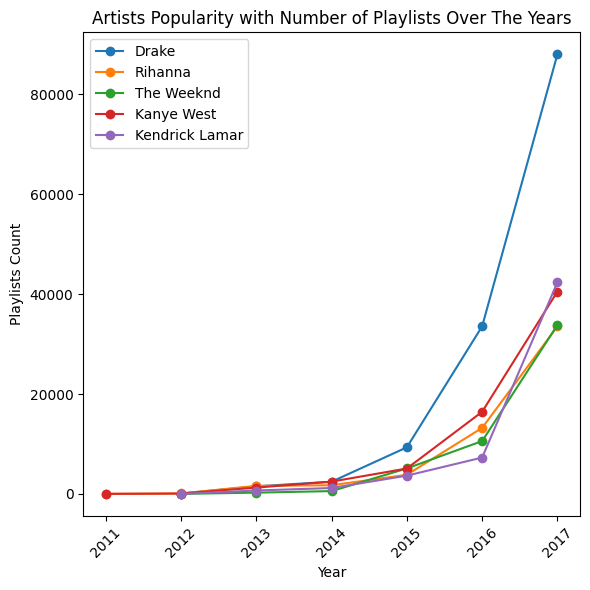

<Figure size 640x480 with 0 Axes>

In [159]:
data = playlists_per_artists.collect()

artist_data = {}
for row in data:
    artist_name = row['artist_name']
    year = row['year']
    count = row['count']
    if artist_name not in artist_data:
        artist_data[artist_name] = []
    artist_data[artist_name].append((year, count))

#sort the data
for artist in artist_data:
    artist_data[artist].sort()

plt.figure(figsize=(6, 6))
for artist, values in artist_data.items():
    years, counts = zip(*values)
    plt.plot(years, counts, marker="o", label=artist)

plt.xlabel("Year")
plt.ylabel("Playlists Count")
plt.title("Artists Popularity with Number of Playlists Over The Years")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Task 3 - Playlists's behavior

24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/29 20:13:15 WARN RowBasedKeyValueBatch: Calling spill() on

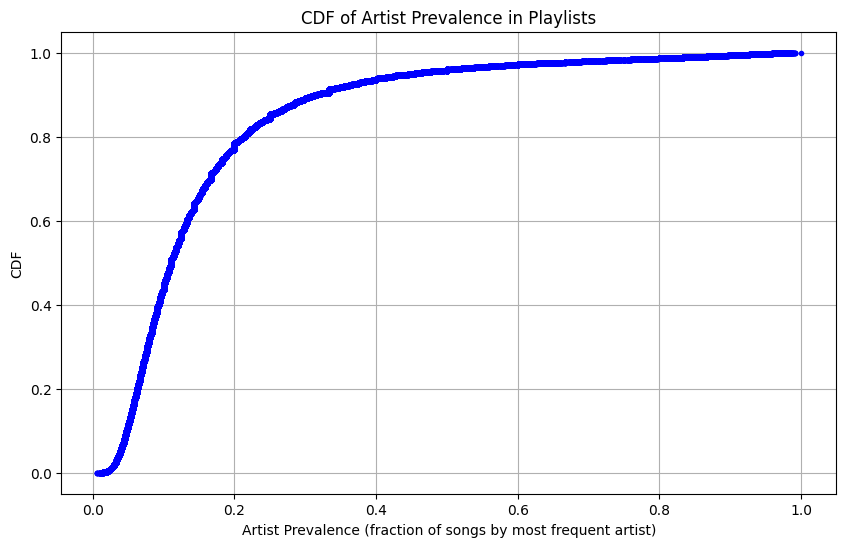

In [146]:
#calculate the number of appearances of each artist per playlist
artist_counts = df_tracks.groupBy("pid", "artist_name").count()

#calculate the highest number of appearances per playlist
most_frequent_artist = artist_counts.groupBy("pid").agg(
    F.max("count").alias("most_frequent_artist_count")
)

#calculate the number of musics per playlist
total_songs_in_playlist = df_tracks.groupBy("pid").count().alias("total_songs")

#calculate the prevalence of the most frequent artist per playlist
artist_prevalence = most_frequent_artist.join(total_songs_in_playlist, on="pid").select("pid",
                                                                (F.col("most_frequent_artist_count") / F.col("count")).alias("artist_prevalence")
)

prevalence_values = [row["artist_prevalence"] for row in artist_prevalence.collect()]

#sorting the values
prevalence_values = np.sort(prevalence_values)

cdf = np.arange(1, len(prevalence_values) + 1) / len(prevalence_values)

plt.figure(figsize=(10, 6))
plt.plot(prevalence_values, cdf, marker=".", linestyle="none", color="b")
plt.title("CDF of Artist Prevalence in Playlists")
plt.xlabel("Artist Prevalence (fraction of songs by most frequent artist)")
plt.ylabel("CDF")
plt.grid(True)
plt.show()